# MIMO-OFDM Channel Estimation: LSE vs MMSE
This notebook compares Least Squares (LSE) and Minimum Mean Square Error (MMSE) channel estimation for a simple MIMO-OFDM system. We will:

1. Define system parameters and pilot configuration.
2. Implement channel estimation functions.
3. Run single-trial simulations with QPSK and OFDM.
4. Conduct Monte Carlo trials to compute mean and median MSE.
5. Visualize the MSE distribution and final-trial constellations.


## Cell 1: Imports and System Parameters

**Description:** Load necessary libraries and set up system-wide constants.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# OFDM and MIMO settings
nFFT = 64               # Number of subcarriers (FFT size)
nCP  = 16               # Cyclic prefix length
Nt   = 1                # Number of transmit antennas
Nr   = 1                # Number of receive antennas
nTaps = 2               # Channel impulse response taps
noiseVar = 0.2          # AWGN noise variance (N₀)

# Pilot configuration: one pilot every 4 subcarriers
pilot_positions = np.arange(0, nFFT, 4)

# QPSK modulation
bits_per_symbol = 2     # 2 bits per symbol (QPSK)

# Monte Carlo simulation
nTrials = 100           # Number of independent trials

## Cell 2: Channel Estimation Functions

**Description:** Define functions to estimate the channel in time and frequency domains using LSE and MMSE.

In [17]:
def estimate_channel(rx_symbols, pilot_syms, method='lse'):
    """
    Estimate MIMO-OFDM channel taps (time/frequency) per receive antenna.

    Args:
        rx_symbols : (nFFT x Nr) array of received subcarrier symbols.
        pilot_syms : (nP x Nt) array of known pilot symbols.
        method     : 'lse' or 'mmse'.

    Returns:
        h_time : (Nr x Nt x nTaps) time-domain channel taps.
        H_freq : (Nr x Nt x nFFT) frequency-domain responses.
    """
    nP = pilot_positions.size
    # DFT rows for pilot positions
    dft = np.exp(-2j*np.pi * np.outer(pilot_positions, np.arange(nFFT)) / nFFT)[:, :nTaps]

    # Build A matrix: block-diagonal of pilots * DFT
    A = np.zeros((nP, Nt*nTaps), dtype=complex)
    for tx in range(Nt):
        A[:, tx*nTaps:(tx+1)*nTaps] = np.diag(pilot_syms[:, tx]) @ dft

    # Received pilot symbols
    Yp = rx_symbols[pilot_positions, :]

    # Prepare outputs
    h_time = np.zeros((Nr, Nt, nTaps), dtype=complex)
    H_freq = np.zeros((Nr, Nt, nFFT), dtype=complex)

    # Estimate per RX antenna
    for rx in range(Nr):
        y = Yp[:, rx]
        if method == 'lse':
            h_vec = np.linalg.pinv(A) @ y
        else:
            R = A.conj().T @ A + noiseVar * np.eye(Nt*nTaps)
            h_vec = np.linalg.solve(R, A.conj().T @ y)

        # Extract taps and compute FFT
        for tx in range(Nt):
            idx = slice(tx*nTaps, (tx+1)*nTaps)
            h_time[rx, tx, :] = h_vec[idx]
            H_freq[rx, tx, :] = np.fft.fft(h_vec[idx], nFFT)

    return h_time, H_freq

## Cell 3: Single-Trial OFDM Simulation

**Description:** Perform one end-to-end trial: QPSK mapping, OFDM modulation, channel, noise addition, estimation, and equalization.


In [18]:
def run_trial(method):
    # 1) QPSK symbol generation
    nBits = Nt * nFFT * bits_per_symbol
    bits = np.random.randint(0, 2, nBits)
    syms = (1/np.sqrt(2))*((1-2*bits[0::2]) + 1j*(1-2*bits[1::2]))
    syms = syms.reshape(nFFT, Nt)

    # 2) Pilot extraction
    pilot_syms = syms[pilot_positions, :]

    # 3) OFDM modulation (IFFT + CP)
    ifft_out = np.fft.ifft(syms, axis=0) * np.sqrt(nFFT)
    tx_sig = np.vstack([ifft_out[-nCP:, :], ifft_out])

    # 4) Rayleigh channel modeling
    pdp = np.array([0.8, 0.2])  # power delay profile
    ch_time = pdp * (np.random.randn(Nr, Nt, nTaps) + 1j*np.random.randn(Nr, Nt, nTaps))

    # 5) Convolve and add noise
    total_len = nFFT + nCP + nTaps - 1
    rx_full = np.zeros((total_len, Nr), dtype=complex)
    for rx in range(Nr):
        for tx in range(Nt):
            rx_full[:, rx] += np.convolve(tx_sig[:, tx], ch_time[rx, tx, :])
    rx_full += np.sqrt(noiseVar/2)*(np.random.randn(*rx_full.shape) + 1j*np.random.randn(*rx_full.shape))

    # 6) Remove CP and FFT
    rx_no_cp = rx_full[nCP:nCP+nFFT, :]
    rx_syms = np.fft.fft(rx_no_cp, axis=0)/np.sqrt(nFFT)

    # 7) Channel estimation & equalization
    _, H_est = estimate_channel(rx_syms, pilot_syms, method)
    eq = np.zeros_like(syms)
    for sc in range(nFFT):
        H_sc = H_est[:,:,sc]
        if method == 'lse':
            eq[sc,:] = np.linalg.pinv(H_sc) @ rx_syms[sc,:]
        else:
            eq[sc,:] = np.linalg.solve(H_sc.conj().T@H_sc + noiseVar*np.eye(Nt),
                                       H_sc.conj().T@rx_syms[sc,:])
    # 8) MSE calculation
    mse = np.mean(np.abs(eq - syms)**2)
    return mse, syms, eq

## Cell 4: Monte Carlo Simulation

**Description:** Run multiple trials, compute mean & median MSE for both LSE and MMSE.


In [19]:
mse_lse_list, mse_mmse_list = [], []
for _ in range(nTrials):
    m_lse, _, _ = run_trial('lse')
    m_mmse, _, _ = run_trial('mmse')
    mse_lse_list.append(m_lse)
    mse_mmse_list.append(m_mmse)

mean_lse, med_lse = np.mean(mse_lse_list), np.median(mse_lse_list)
mean_mmse, med_mmse = np.mean(mse_mmse_list), np.median(mse_mmse_list)

print(f"Over {nTrials} trials:")
print(f"  LSE  → mean MSE = {mean_lse:.6f}, median = {med_lse:.6f}")
print(f"  MMSE → mean MSE = {mean_mmse:.6f}, median = {med_mmse:.6f}")

Over 100 trials:
  LSE  → mean MSE = 0.972967, median = 0.360332
  MMSE → mean MSE = 0.272633, median = 0.214324


## Cell 5: MSE Distribution Histogram

**Description:** Visualize the spread of MSE to highlight outliers.

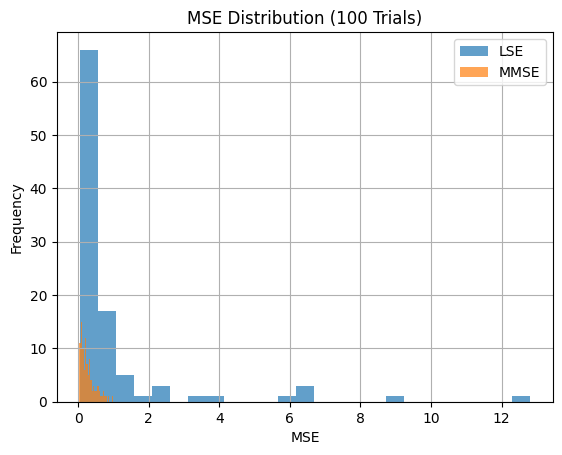

In [20]:
plt.figure()
plt.hist(mse_lse_list,  bins=25, alpha=0.7, label='LSE')
plt.hist(mse_mmse_list, bins=25, alpha=0.7, label='MMSE')
plt.xlabel('MSE'); plt.ylabel('Frequency')
plt.title(f'MSE Distribution ({nTrials} Trials)')
plt.legend(); plt.grid()
plt.show()

## Cell 6: Final-Trial Constellation Plot

**Description:** Re-run last trial to plot transmitted vs. equalized symbols.

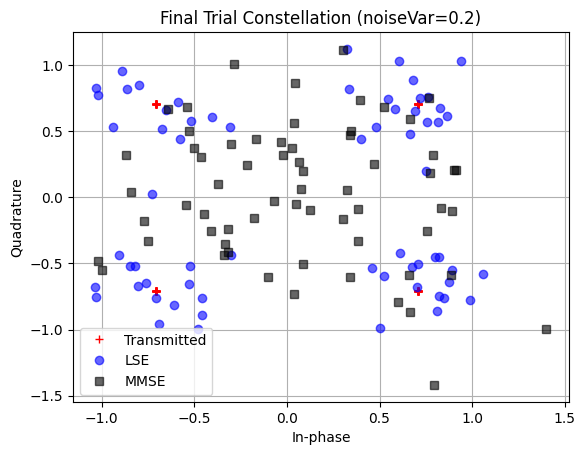

In [21]:
# Re-run last trial
_, tx_syms_last, eq_lse_last = run_trial('lse')
_, _,                 eq_mmse_last = run_trial('mmse')

plt.figure()
plt.plot(tx_syms_last.real.flatten(),  tx_syms_last.imag.flatten(),  'r+', label='Transmitted')
plt.plot(eq_lse_last.real.flatten(),  eq_lse_last.imag.flatten(),  'bo', alpha=0.6, label='LSE')
plt.plot(eq_mmse_last.real.flatten(), eq_mmse_last.imag.flatten(), 'ks', alpha=0.6, label='MMSE')
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.title(f'Final Trial Constellation (noiseVar={noiseVar})')
plt.legend(); plt.grid()
plt.show()